In [82]:
import pandas as pd
import numpy as np
import sklearn
import itertools
import matplotlib.pyplot as plt
from pathlib import Path

In [83]:
def filter_df(df_raw):
    new_columns = df_raw.columns + " " + df_raw.iloc[0] + " " + df_raw.iloc[1]
    df_filt = df_raw.copy()
    df_filt.columns = new_columns
    df_filt = df_filt.drop([0, 1]).reset_index(drop=True)
    df_filt.head()
    df = df_filt.apply(pd.to_numeric)
    return df

Node 83 is on the top (= Node 332)

Node 156 is on the side (= Node 359)

In [84]:
data_folder = "Data/"
health_status = ["imperfect","perfect"]
structure_status = ["Long","Short"]
force_status = ["1","2"]
combinations = list(itertools.product(health_status,structure_status,force_status))
name_assignment = {
    "Unnamed: 0 X 0.": "time",
    "_U:Magnitude PI: PART-1-1 N: 83 0.": "mag_top",
    "_U:Magnitude PI:.1 PART-1-1 N: 156 0.": "mag_side",
    "_U:U1 PI: PART-1- 1 N: top 0.": "x_top",
    "_U:U2 PI: PART-1- 1 N: top 0.": "y_top",
    "_U:U3 PI: PART-1- 1 N: top 0.": "z_top",
    "_U:U1 PI: PART-1-.1 1 N: side 0.": "x_side",
    "_U:U2 PI: PART-1-.1 1 N: side 0.": "y_side",
    "_U:U3 PI: PART-1-.1 1 N: side 0.": "z_side",
}
def get_df(health, structure, force):
    folder_name = f"class_{1 if health=='imperfect' else 0}_{health}_structure"
    filename = f"Displacement_{structure}_Structure_{force}MN_Force.rpt"
    file = Path(folder_name) / filename
    df = pd.read_fwf(data_folder+str(file))
    df = filter_df(df)
    df.columns = name_assignment.values()

    # Add feature as column
    if health == "imperfect":
        df["health"] = pd.Series(np.zeros_like(df.index))
    elif health == "perfect":
        df["health"] = pd.Series(np.ones_like(df.index))

    if structure == "Long":
        df["structure"] = pd.Series(np.ones_like(df.index))
    elif structure == "Short":
        df["structure"] = pd.Series(np.zeros_like(df.index))
    
    df["force"] = pd.Series(int(force)*np.ones_like(df.index))

    return df

dfs = []
for type in combinations:
    df = get_df(*type)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

In [85]:
pd.Series(range(len(df)))

0        0
1        1
2        2
3        3
4        4
      ... 
795    795
796    796
797    797
798    798
799    799
Length: 800, dtype: int64

# Inspect

<Axes: xlabel='time', ylabel='health'>

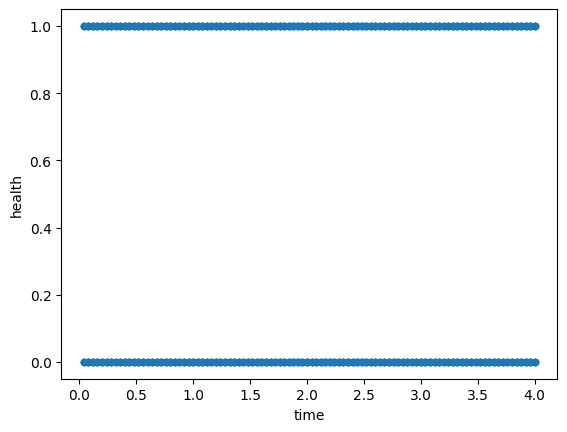

In [86]:
df.plot(x="time", y="health", kind="scatter")

<Axes: xlabel='time', ylabel='mag_top'>

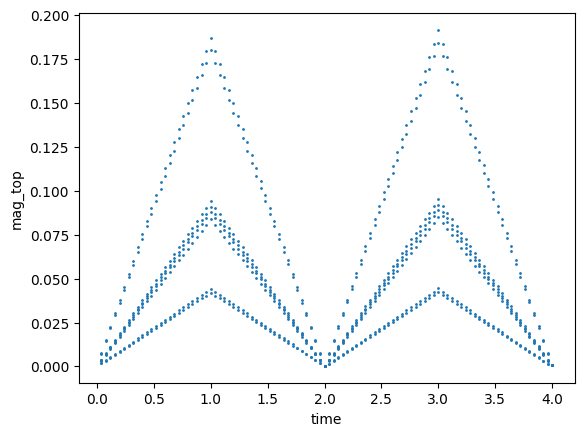

In [87]:
df.plot(x="time", y="mag_top", kind="scatter", s=1)

# Train-Test Split

In [88]:
X_raw, y_raw = df.drop(columns=["health"]), df["health"]
X_train_raw, X_test_raw, y_train, y_test = sklearn.model_selection.train_test_split(
    X_raw, y_raw, test_size = 0.1, random_state = 0, shuffle=True,
)

# Data standardization

In [89]:
continuous_x_columns = ["time","mag_top", "mag_side", "x_top", "y_top", "z_top", "x_side", "y_side", "z_side"]
binary_x_columns = ["structure","force"]
x_columns = continuous_x_columns+binary_x_columns
y_column = "health"

In [90]:

def standardize(X_train_raw, X_test_raw):
    scaler = sklearn.preprocessing.StandardScaler()

    scaler.fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    return X_train, X_test

X_train, X_test = standardize(X_train_raw, X_test_raw)

In [91]:
def check_dataset(X_train_raw, X_test_raw):
    train_indices = set(X_train_raw.index)
    test_indices = set(X_test_raw.index)
    overlap = train_indices.intersection(test_indices)
    print(f"Number of overlapping indices: {len(overlap)}")
    if len(overlap) > 0:
        print("Warning: Train and test sets are not independent!")
        raise ValueError
    else:
        print("Train and test sets are independent.")

check_dataset(X_train_raw, X_test_raw)

Number of overlapping indices: 0
Train and test sets are independent.


In [92]:
overlap_time = set(X_train_raw["time"]).intersection(set(X_test_raw["time"]))
print(f"Number of overlapping 'time' values: {len(overlap_time)}")

Number of overlapping 'time' values: 57


# Logistic Regression

In [93]:
model = sklearn.linear_model.LogisticRegression(random_state=0)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [94]:
model.score(X_test, y_test), model.score(X_train, y_train)

(0.575, 0.5597222222222222)

Question: Why is score on test better than on train?

# Support Vector Machine

In [95]:
model = sklearn.svm.SVC()
model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [96]:
model.score(X_test, y_test), model.score(X_train, y_train)

(0.925, 0.9375)

# Decision tree

In [97]:
model = sklearn.tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [98]:
model.score(X_test, y_test), model.score(X_train, y_train)

(1.0, 1.0)

In [99]:
acc_df = pd.DataFrame(columns=['col', 'acc'], index=range(len(x_columns)))

for i, c in enumerate(x_columns):

    model.fit(X_train[:,i][:, None], y_train)

    y_pred = model.predict(X_test[:,i][:, None])
    acc_df.iloc[i] = [c, sklearn.metrics.accuracy_score(y_test, y_pred)*100]

acc_df.sort_values('acc',ascending=False)


,col,acc
4,y_top,93.75
3,x_top,90.0
1,mag_top,88.75
2,mag_side,87.5
5,z_top,76.25
6,x_side,61.25
7,y_side,60.0
8,z_side,56.25
9,structure,43.75
10,force,43.75


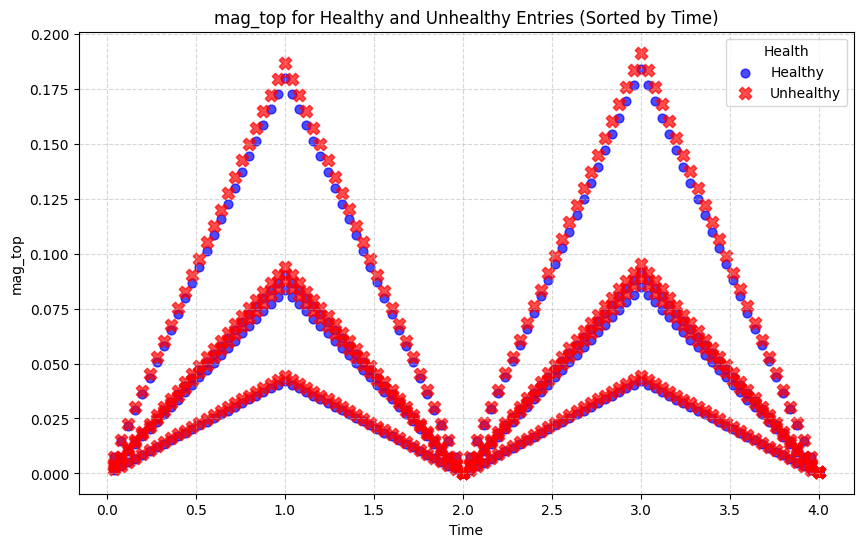

In [100]:
df_sorted = df.sort_values("time")
plt.figure(figsize=(10,6))

healthy = df_sorted[df_sorted["health"] == 1]
unhealthy = df_sorted[df_sorted["health"] == 0]

plt.scatter(
    healthy["time"], healthy["mag_top"],
    c="blue", marker="o", s=40, alpha=0.7, label="Healthy"
)
plt.scatter(
    unhealthy["time"], unhealthy["mag_top"],
    c="red", marker="X", s=80, alpha=0.7, label="Unhealthy"
)

plt.xlabel("Time")
plt.ylabel("mag_top")
plt.title("mag_top for Healthy and Unhealthy Entries (Sorted by Time)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Health")
plt.show()

# Task 3

### Predict displacement mag_top at time t.

Do not use x_top, y_top or z_top.

In [101]:
df

,time,mag_top,mag_side,x_top,y_top,z_top,x_side,y_side,z_side,health,structure,force
0,0.04,0.003779,0.003049,0.003779,0.002734,-0.000001,-0.000005,0.000008,0.001350,0,1,1
1,0.08,0.007556,0.006097,0.007556,0.005467,-0.000002,-0.000010,0.000016,0.002700,0,1,1
2,0.12,0.011332,0.009144,0.011332,0.008198,-0.000003,-0.000016,0.000026,0.004049,0,1,1
3,0.16,0.015106,0.012189,0.015106,0.010928,-0.000004,-0.000021,0.000036,0.005398,0,1,1
4,0.20,0.018879,0.015232,0.018879,0.013657,-0.000005,-0.000026,0.000048,0.006746,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
795,3.84,0.013274,0.017701,-0.012151,-0.017694,-0.000040,-0.000050,-0.005345,0.000470,1,0,2
796,3.88,0.009895,0.013273,-0.009113,-0.013265,-0.000035,-0.000042,-0.003855,0.000471,1,0,2
797,3.92,0.006521,0.008850,-0.006077,-0.008837,-0.000029,-0.000033,-0.002366,0.000473,1,0,2
798,3.96,0.003167,0.004438,-0.003042,-0.004413,-0.000023,-0.000025,-0.000879,0.000477,1,0,2


In [102]:
X_raw, y_raw = df.drop(columns=["mag_top","x_top","y_top","z_top"]), df["mag_top"]
X_train_raw, X_test_raw, y_train, y_test = sklearn.model_selection.train_test_split(
    X_raw, y_raw, test_size = 0.1, random_state = 0, shuffle=True,
)
check_dataset(X_train_raw, X_test_raw)
X_train, X_test = standardize(X_train_raw, X_test_raw)

Number of overlapping indices: 0
Train and test sets are independent.


In [103]:
model = sklearn.tree.DecisionTreeRegressor()
model.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [104]:
model.score(X_test, y_test), model.score(X_train, y_train)

(0.9999418225294362, 1.0)

# Neural Network Regressor

In [121]:
model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,100,100))
model.fit(X_train, y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(100, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True


In [ ]:
# 100, 100, 100 (underfitting)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.9450197987939765, 0.9652715360204638)

In [ ]:
# 1000, 100, 100
model.score(X_test, y_test), model.score(X_train, y_train)

(0.9940451935199855, 0.9961038432321017)

In [ ]:
# 1000, 1000, 100 (overfitting)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.9859669282092717, 0.9869351153078444)